In [112]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [113]:
train_dataset_path = 'seg_train/'
validation_dataset_path = 'seg_test/'

In [114]:
IMG_WIDTH = 250
IMG_HEIGHT = 250
BATCH_SIZE = 3

In [115]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    zoom_range=0.2,          # Slight zoom
    rotation_range=15,       # Rotate images up to 15 degrees
    width_shift_range=0.1,   # Shift width slightly
    height_shift_range=0.1,  # Shift height slightly
    fill_mode='nearest'
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 207 images belonging to 7 classes.


In [116]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 23 images belonging to 7 classes.


In [117]:
labels = {value: key for key, value in train_generator.class_indices.items()}
print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : damage_seat
1 : damaged_window
2 : food_dataset
3 : unhyg_comp
4 : unhyg_toilet
5 : unhyg_washbasin
6 : violence


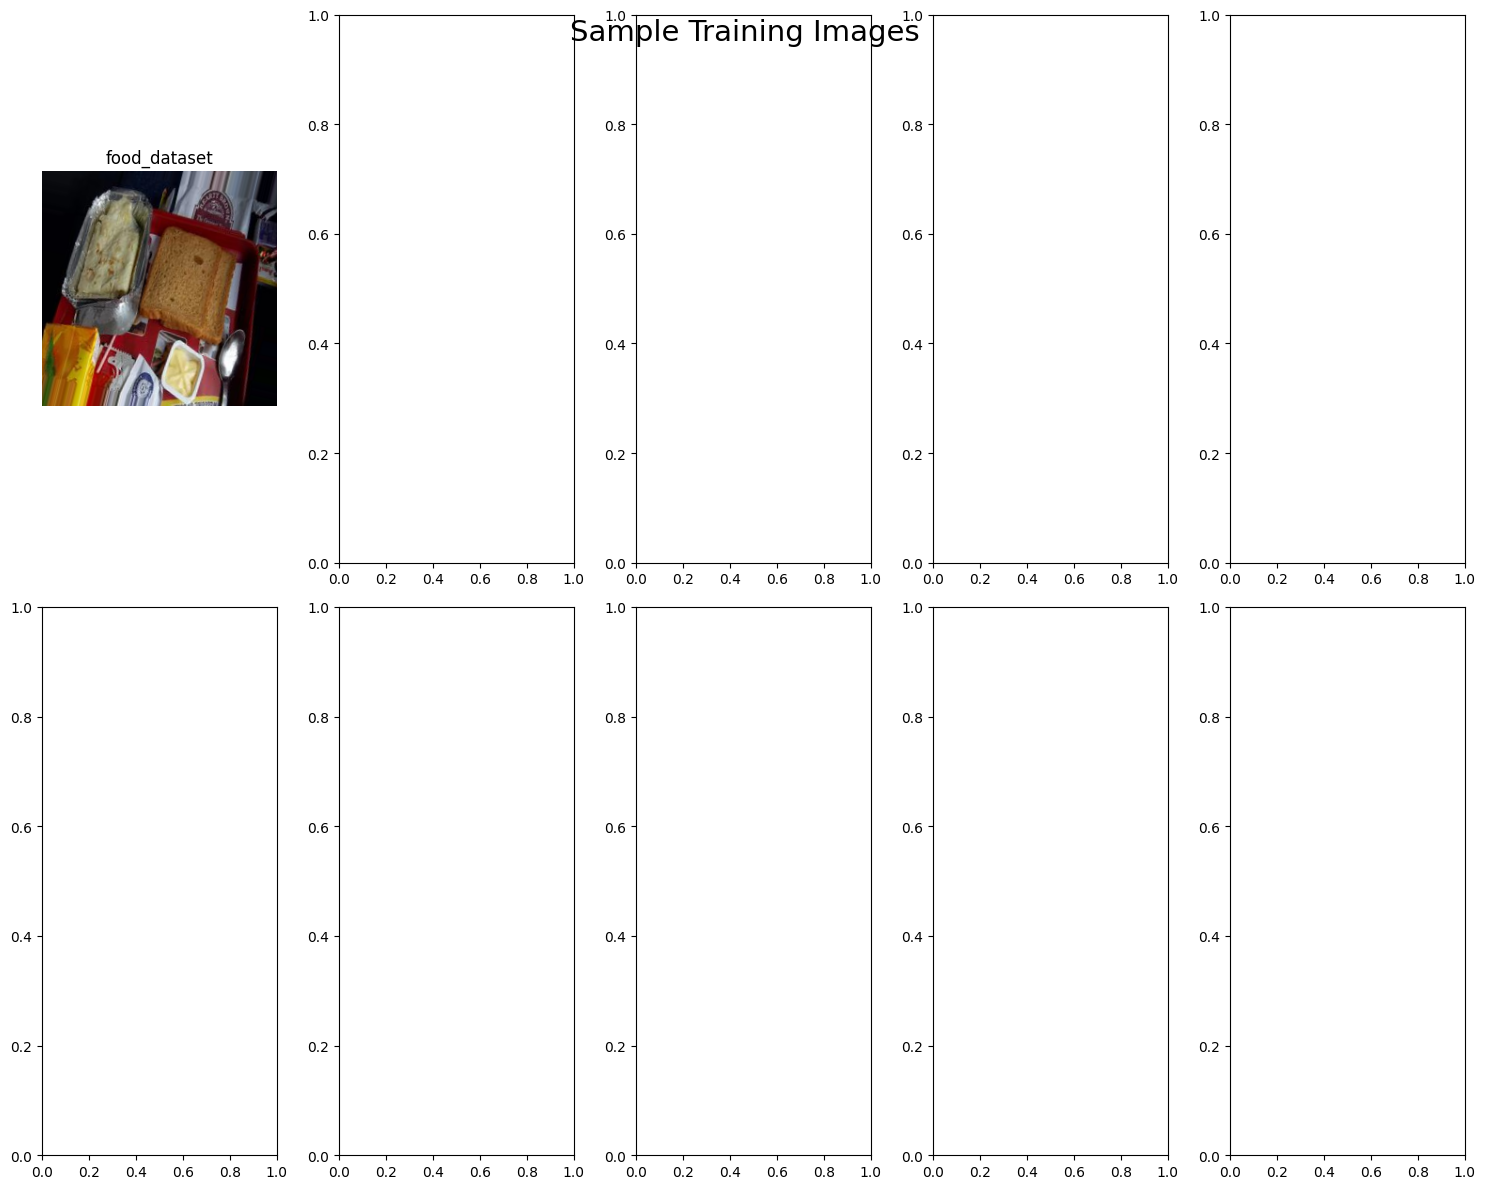

In [119]:
# Visualize sample training images
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0
for i in range(1):
    for j in range(1):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1
plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [123]:
# def create_model():
#     model = Sequential([
#         Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
#         Activation('relu'),
#         MaxPooling2D(pool_size=(2, 2)),
#         BatchNormalization(),
        
#         Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
#         Activation('relu'),
#         MaxPooling2D(pool_size=(2, 2)),
#         BatchNormalization(),
        
#         Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
#         Activation('relu'),
#         MaxPooling2D(pool_size=(2, 2)),
#         BatchNormalization(),
        
#         Flatten(),
        
#         Dense(units=256, activation='relu'),
#         Dropout(0.5),
#         Dense(units=7, activation='softmax')
#     ])
    
#     return model
def create_model():
    model = Sequential([
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.0001)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=128, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(0.6),  # Increased dropout rate
        Dense(units=7, activation='softmax')
    ])
    
    return model


In [124]:
cnn_model = create_model()

In [125]:
print(cnn_model.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 248, 248, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 248, 248, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 124, 124, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 124, 124, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 122, 122, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 122, 122, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 61, 61, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 119072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    15,241,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,262,887 (58.22 MB)

 Trainable params: 15,262,695 (58.22 MB)

 Non-trainable params: 192 (768.00 B)

None


In [126]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [127]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [128]:
optimizer = Adam(learning_rate=0.0005)  # Reduced learning rate
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])


In [ ]:
# cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [129]:
history = cnn_model.fit(
    train_generator,
    epochs=50,  # Increased epochs for better training
    validation_data=validation_generator,
    verbose=2,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/50
69/69 - 19s - 277ms/step - accuracy: 0.3092 - loss: 23.1536 - val_accuracy: 0.1304 - val_loss: 12.0222 - learning_rate: 5.0000e-04
Epoch 2/50
69/69 - 18s - 258ms/step - accuracy: 0.4396 - loss: 24.2399 - val_accuracy: 0.1304 - val_loss: 9.8436 - learning_rate: 5.0000e-04
Epoch 3/50
69/69 - 17s - 245ms/step - accuracy: 0.3430 - loss: 28.3880 - val_accuracy: 0.2609 - val_loss: 3.7511 - learning_rate: 5.0000e-04
Epoch 4/50
69/69 - 17s - 243ms/step - accuracy: 0.4444 - loss: 20.9895 - val_accuracy: 0.3478 - val_loss: 2.9311 - learning_rate: 5.0000e-04
Epoch 5/50
69/69 - 17s - 246ms/step - accuracy: 0.4831 - loss: 18.0189 - val_accuracy: 0.2174 - val_loss: 6.4357 - learning_rate: 5.0000e-04
Epoch 6/50
69/69 - 16s - 232ms/step - accuracy: 0.4058 - loss: 14.9668 - val_accuracy: 0.1739 - val_loss: 6.0830 - learning_rate: 5.0000e-04
Epoch 7/50
69/69 - 16s - 231ms/step - accuracy: 0.5411 - loss: 8.6591 - val_accuracy: 0.1739 - val_loss: 7.9602 - learning_rate: 5.0000e-04
Epoch 8/50
69

In [130]:
train_accuracy = history.history.get('accuracy', [])
val_accuracy = history.history.get('val_accuracy', [])
train_loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])
learning_rate = history.history.get('lr', [])

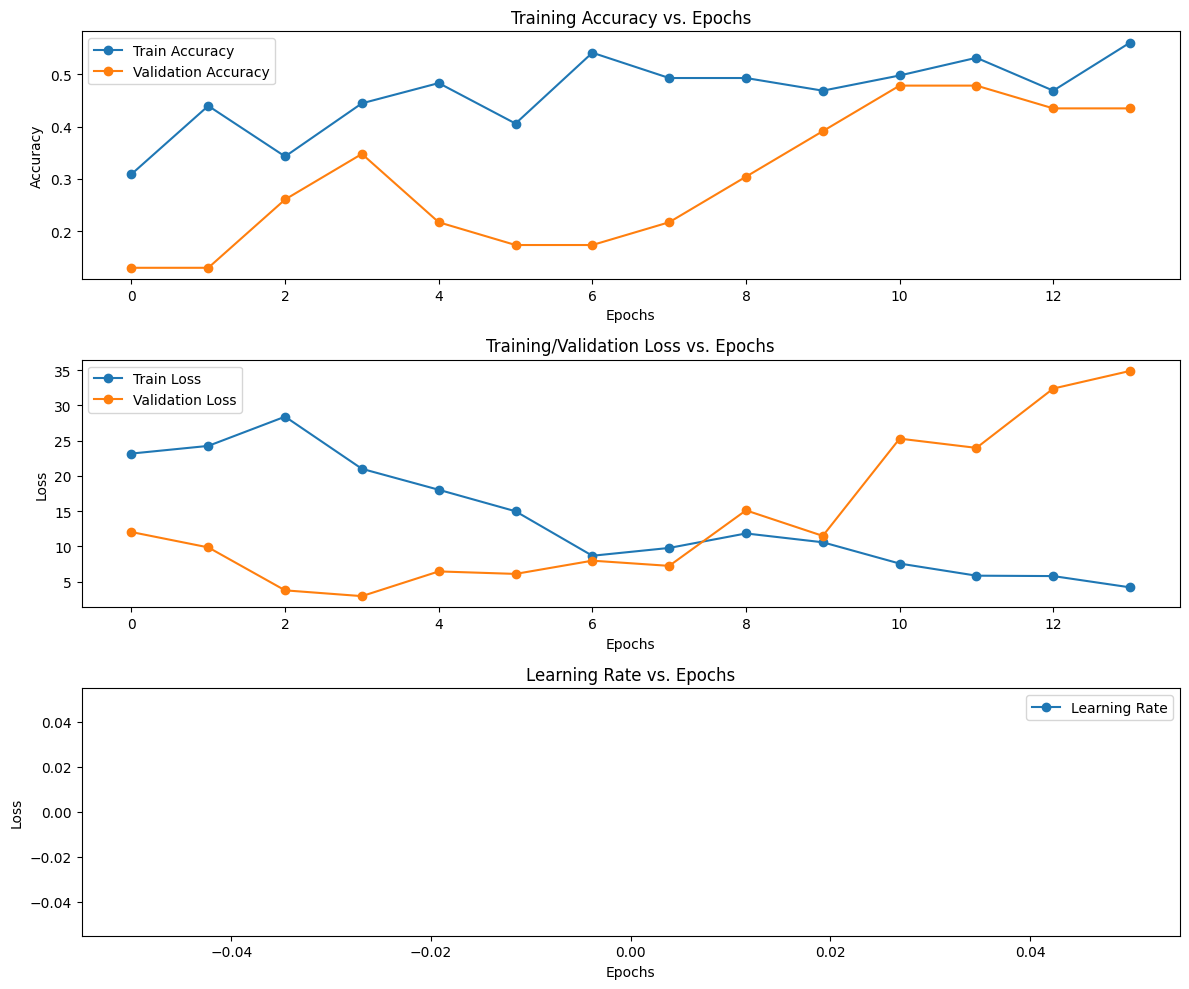

In [131]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [132]:
test_dataset = 'seg_test/'

In [133]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 23 images belonging to 7 classes.


In [134]:
predictions = cnn_model.predict(test_generator)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


IndexError: index 3 is out of bounds for axis 0 with size 3

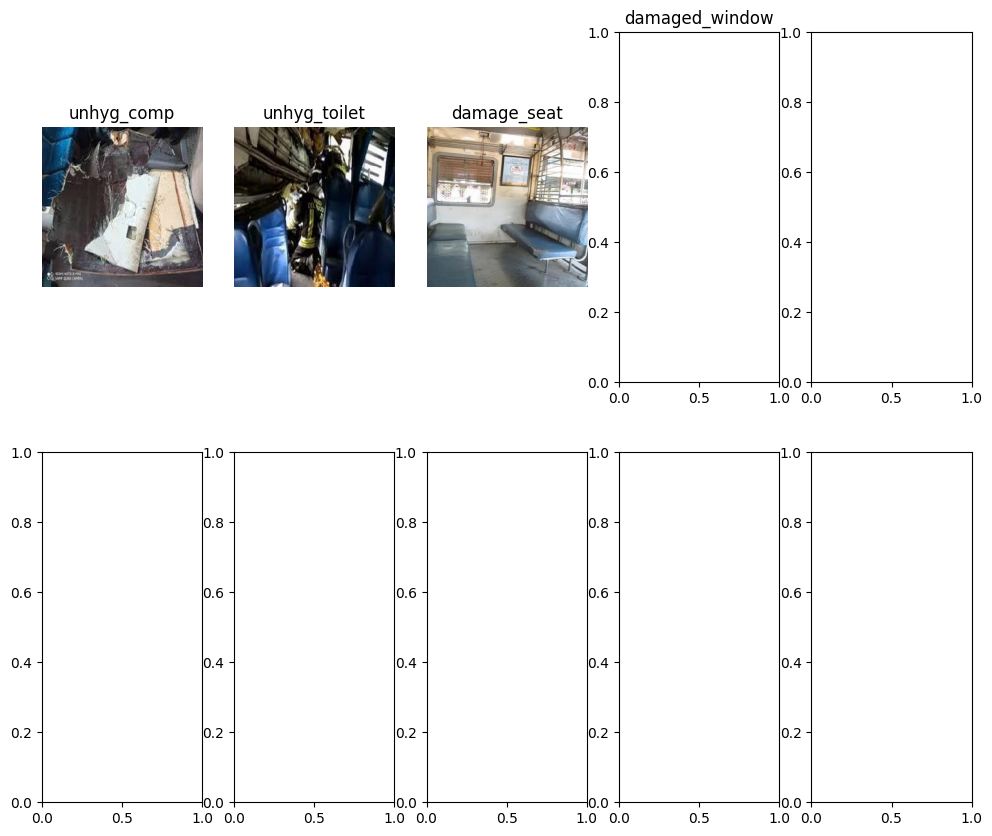

In [135]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()


In [136]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3767 - loss: 2.9409


In [137]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     2.9174447059631348
Test Accuracy: 0.3478260934352875


In [138]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

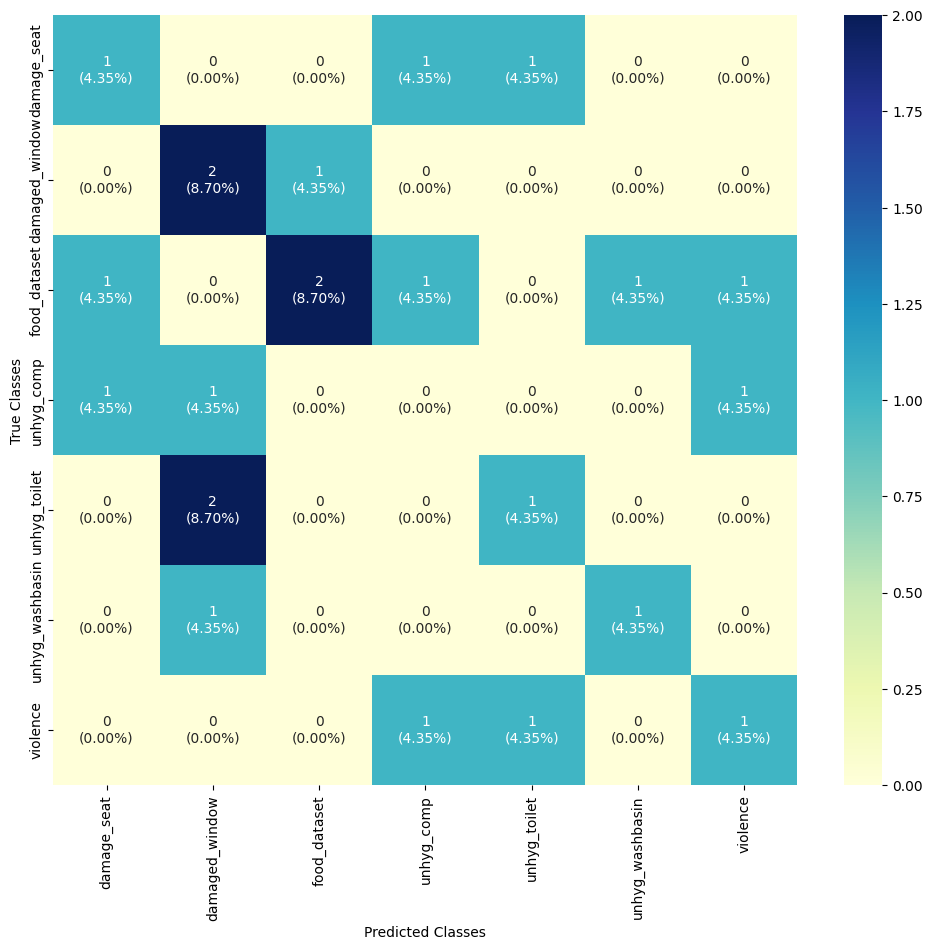

In [139]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(7, 7)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [140]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

                 precision    recall  f1-score   support

    damage_seat       0.33      0.33      0.33         3
 damaged_window       0.33      0.67      0.44         3
   food_dataset       0.67      0.33      0.44         6
     unhyg_comp       0.00      0.00      0.00         3
   unhyg_toilet       0.33      0.33      0.33         3
unhyg_washbasin       0.50      0.50      0.50         2
       violence       0.33      0.33      0.33         3

       accuracy                           0.35        23
      macro avg       0.36      0.36      0.34        23
   weighted avg       0.39      0.35      0.35        23



In [141]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [142]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

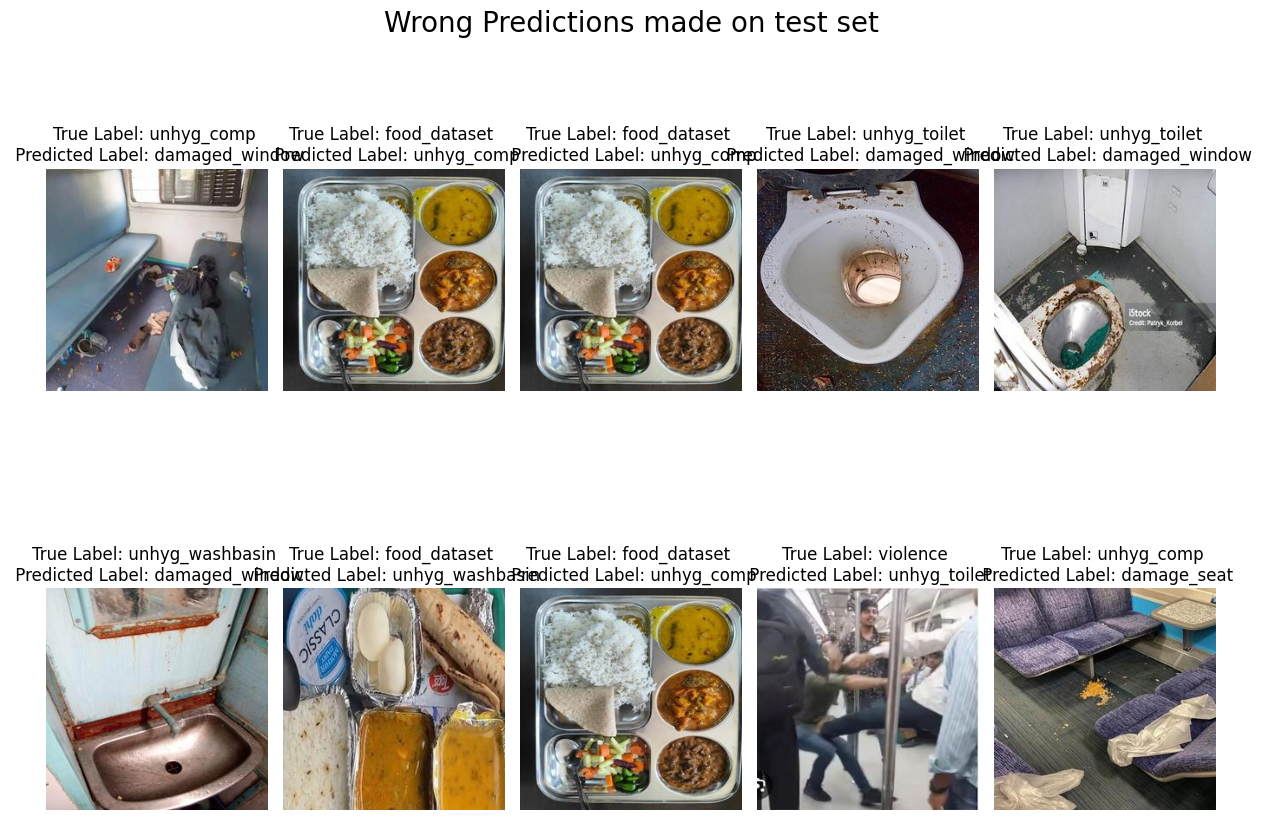

In [143]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()

In [144]:
# Save the model to a directory
model_save_path = 'my_model.h5'
cnn_model.save(model_save_path)
